<a href="https://colab.research.google.com/github/uurspecial/simpson/blob/main/pytorch_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The complete training and evaluation process with PyTorch

## 學習目標
- 我們已經學過 Gradient Descent, Backpropagation, 以及更進階的梯度下降最佳化方法 (如 SGD, Adam 等)
- 因此我們接下來要實作一個完整的神經網路訓練流程，同時也將介紹評估流程

## 測試現在這個 Colab 環境是否已經使用 GPU
- 否則等下可能會需要重新啟動 Colab 環境

In [ ]:
import torch
torch.cuda.is_available() # 結果需要顯示為 True

True

## PyTorch 常用套件

| 套件名稱 | 主要內容 |
|-|-|
|[`torch.nn as nn`](https://pytorch.org/docs/stable/nn.html) | 與模型架構相關的函數，包含各種層與目標函數的實作 |
|[`torch.optim`](https://pytorch.org/docs/stable/optim.html) | 與模型最佳化有相關的函數 (optim: optimization) |
|[`torchvision`](https://pytorch.org/vision/stable/index.html) | 與電腦視覺 (影像) 任務有相關的函數 |
|[`torchvision.transforms`](https://pytorch.org/vision/0.9/transforms.html) | 幫助進行影像資料前處理的函數 |

In [ ]:
# 引入本教學所需要的套件

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 載入資料
- 本教學使用的是 MNIST 手寫字辨識資料集 (by [Yann LeCun](http://yann.lecun.com/exdb/mnist/))

![MNIST](https://upload.wikimedia.org/wikipedia/commons/b/b1/MNIST_dataset_example.png)

In [ ]:
# 載入 MNIST 資料並進行影像前處理
# PyTorch 官方範例連結：https://github.com/pytorch/examples/blob/main/mnist_forward_forward/main.py#L160C23-L160C43

transform = transforms.Compose([transforms.ToTensor()]) # 不進行前處理，但把讀進來的資料轉為 tensors

# 進行資料前處理，將數值轉為 -1 到 1 之間
# MNIST 影像的數值是 0 ~ 255，且是灰階影像 (只有一個 channel)
# 因此 transforms.Normalize 函數內的數字要設為 (0.5,), (0.5,)，第一個數字代表 mean；第二個數字代表 std
# 如果是彩色影像的話，transforms.Normalize 函數內的數字要改為 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
# transform = transforms.Compose(
#     [
#         transforms.ToTensor(),
#         transforms.Normalize((0.5,), (0.5,)), # PyTorch 官方建議 (0.1307,), (0.3081,)
#     ]
# )

# 載入 MNIST 資料
# `train=False` 代表載入 test 資料
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

## 觀察資料

In [ ]:
print(f"MNIST 訓練資料有 {len(trainset)} 筆")
print(f"MNIST 測試資料有 {len(testset)} 筆")

MNIST 訓練資料有 60000 筆
MNIST 測試資料有 10000 筆


In [ ]:
# 沒有 ToTensor()
tmp = torchvision.datasets.MNIST(root="./data", train=False, download=True)

# 取得第一張圖片和標籤
image, label = tmp[0]
print(f"image 的資料格式為: {type(image)}")

image 的資料格式為: <class 'PIL.Image.Image'>


In [ ]:
# Jupyter Notebook 內建支援顯示 PIL 影像
# 所以直接輸入在程式格中執行後會自動顯示原始影像

image

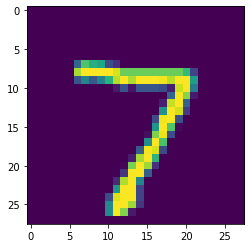

In [ ]:
# maplotlib 的 imshow 功能可以顯示 PIL 影像
# 但如果是灰階影像的話，它會幫套上 colormap，所以看起來很像彩色影像

plt.imshow(image)
# plt.imshow(image, cmap="gray") # 若資料是灰階影像，應加上 cmap="gray"

In [ ]:
# 觀察有進行 ToTensor() 後的資料

# 取得第一張圖片和標籤
image, label = trainset[0]
print(f"image 的資料格式為: {type(image)}")

image 的資料格式為: <class 'torch.Tensor'>


In [ ]:
image.shape

torch.Size([1, 28, 28])

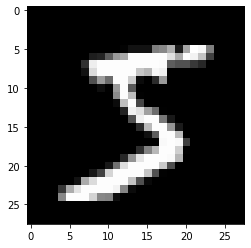

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")

## 建立模型
- 我們使用 multi-layer perceptron (MLP)

In [ ]:
# 定義 MLP 模型
class MLP(nn.Module):
    def __init__(self):
        super().__init__() # 繼承 nn.Module 類別的初始化函數
        hidden_size1 = 256 # 第一層隱藏層的神經元數量
        hidden_size2 = 128 # 第二層隱藏層的神經元數量

        self.layer_1 = nn.Linear(28*28, hidden_size1)
        self.layer_2 = nn.Linear(256, hidden_size2)
        self.cls_layer = nn.Linear(hidden_size2, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28) # 將輸入的 x 轉為 28*28 的形狀 (因為 transform.ToTensor() 會把圖片轉為 1*28*28)
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.cls_layer(x)
        return x

## 將資料分裝成 batches
- 一般來說，我們會將訓練資料打亂 (`shuffle=True`)，驗證/測試資料不打亂
- 我們可以使用 Scikit-learn 的 [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) 來進行資料切分

In [ ]:
# 把 validation set 從 training set 切出來 10%
# random_state: Pass an int for reproducible output

trainset, valset = train_test_split(trainset, test_size=0.1, random_state=42)

In [ ]:
print(f"MNIST 訓練資料有 {len(trainset)} 筆")
print(f"MNIST 訓練資料有 {len(valset)} 筆")
print(f"MNIST 測試資料有 {len(testset)} 筆")

MNIST 訓練資料有 54000 筆
MNIST 訓練資料有 6000 筆
MNIST 測試資料有 10000 筆


In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

## 取得 DataLoader 中的一個 Batch
- 在 PyTorch 中，`DataLoader` 是一個 **可迭代對象 (iterable)**
- 我們可以使用 **`iter()`** 和 **`next()`** 來手動取得一個 batch：
```python
images, labels = next(iter(train_loader))
```

In [ ]:
# 觀察 batches 資料

train_iter = iter(train_loader)  # 取得迭代器
batch_x, batch_y = next(train_iter) # 取出一個 batch
print(batch_x)
print(batch_y)
print(batch_x.shape)
print(batch_y.shape)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [ ]:
# 每次進行 next() 就會取得下一次的迭代

_, batch_y = next(train_iter) # 這邊就單純觀察 y 就好
print(batch_y)
print(batch_y.shape)

tensor([5, 1, 8, 9, 2, 6, 7, 6, 3, 7, 7, 3, 0, 8, 1, 8, 8, 1, 8, 1, 8, 6, 1, 6,
        6, 3, 5, 8, 8, 0, 3, 7, 8, 7, 7, 9, 2, 2, 4, 2, 1, 8, 9, 4, 4, 8, 0, 0,
        1, 7, 9, 8, 8, 1, 9, 1, 4, 5, 2, 0, 3, 1, 6, 5])
torch.Size([64])


## Training process

In [ ]:
# 設定設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 初始化模型、損失函數、optimizer
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/10, Train Loss: 0.3002, Val Loss: 0.1391
Epoch 2/10, Train Loss: 0.1160, Val Loss: 0.0904
Epoch 3/10, Train Loss: 0.0776, Val Loss: 0.0782
Epoch 4/10, Train Loss: 0.0568, Val Loss: 0.0790
Epoch 5/10, Train Loss: 0.0426, Val Loss: 0.0727
Epoch 6/10, Train Loss: 0.0323, Val Loss: 0.0728
Epoch 7/10, Train Loss: 0.0265, Val Loss: 0.0691
Epoch 8/10, Train Loss: 0.0210, Val Loss: 0.0934
Epoch 9/10, Train Loss: 0.0193, Val Loss: 0.0750
Epoch 10/10, Train Loss: 0.0155, Val Loss: 0.0741


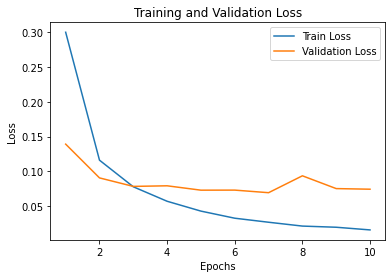

In [ ]:
# 訓練模型
epochs = 10
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # 驗證模型
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

# 繪製 loss 的歷史記錄圖
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print(outputs.shape)
print(outputs.argmax(dim=1))
print(outputs.argmax(dim=1).shape)

torch.Size([48, 10])
tensor([5, 3, 1, 6, 2, 8, 2, 5, 3, 6, 0, 1, 4, 3, 1, 1, 6, 1, 9, 9, 4, 5, 1, 1,
        7, 5, 0, 4, 4, 6, 8, 4, 8, 7, 0, 1, 5, 3, 5, 3, 7, 2, 1, 5, 9, 7, 2, 5],
       device='cuda:0')
torch.Size([48])


In [ ]:
model.eval()
predictions = []
test_loss = 0.0 # 在 test 的時候其實不用算 loss，因為通常我們沒有 test set 的標準答案
test_losses = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        tmp_pred = outputs.argmax(dim=1) # tmp_pred 的型態是 tensor
        predictions.extend(tmp_pred.tolist()) # 如果用 append 的話會變成 [[1, 2, 3], [4, 5, 6]]

        loss = criterion(outputs, labels)
        test_loss += loss.item()
test_losses.append(test_loss / len(test_loader))

In [ ]:
# 檢查一下最後 predictions 的數量是否跟 testset 的資料筆數一致

len(predictions) == len(testset)

True

## 計算分數
- 我們可以使用 Scikit-learn 的 [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) 來幫我們計算準確率 (Accuracy)：
```python
sklearn.metrics.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)
```

In [ ]:
# 把 testset 中的正確答案取出來

test_labels = [example[1] for example in testset]

In [ ]:
accuracy_score(test_labels, predictions)

0.9776